In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import gym
from gym.spaces import Box, Discrete
import time

import scipy.signal

tfd = tfp.distributions

In [2]:
"""
functions in core.py
"""
EPS = 1e-8


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input:
      vector x,
      [x0,
       x1,
       x2]
    output:
      [x0 + discount * x1 + discount^2 * x2,
       x1 + discount * x2,
       x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


def gaussian_likelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + EPS))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)


def make_mlp_model(input_shape, sizes, activation='tanh', output_activation=None):
    """ Build a feedforward neural network. """
    mlp = tf.keras.Sequential()
    mlp.add(tf.keras.layers.Dense(sizes[0], activation=activation, input_shape=(input_shape,)))
    if len(sizes) > 2:
        for size in sizes[1:-1]:
            mlp.add(tf.keras.layers.Dense(size, activation=activation))

    mlp.add(tf.keras.layers.Dense(sizes[-1], activation=output_activation))
    return mlp

def statistics_scalar(x):
    x = np.array(x, dtype=np.float32)
    return np.mean(x), np.std(x)

In [3]:
"""
Actor-Critics
"""


class ActorCritic:
    def __init__(self, obs_dim, hidden_sizes=(64, 64), activation='tanh', output_activation=None, action_space=None, pi_lr=3e-4, vf_lr=1e-3, train_v_iters=80):
        if isinstance(action_space, Box):
            act_dim = len(action_space.sample())
            self.pi_mlp = make_mlp_model(obs_dim, list(hidden_sizes) + [act_dim], activation, output_activation)
            self.policy = self._mlp_gaussian_policy
            self.log_std = tf.Variable(name='log_std', initial_value=-0.5 * np.ones(act_dim, dtype=np.float32))

        elif isinstance(action_space, Discrete):
            act_dim = action_space.n
            self.pi_mlp = make_mlp_model(obs_dim, list(hidden_sizes) + [act_dim], activation, None)
            self.policy = self._mlp_categorical_policy
            self.action_space = action_space
        self.v_mlp = make_mlp_model(obs_dim, list(hidden_sizes) + [1], activation, None)
        # optimizers
        self.pi_optimizer = tf.optimizers.Adam(learning_rate=pi_lr)
        self.vf_optimizer = tf.optimizers.Adam(learning_rate=vf_lr)
        self.train_v_iters = train_v_iters

    @tf.function
    def __call__(self, observation, action):
        pi, logp_pi = self.policy(observation, action)
        v = tf.squeeze(self.v_mlp(observation), axis=1)
        return pi, logp_pi, v

    def _mlp_categorical_policy(self, observation, action):
        act_dim = self.action_space.n
        logits = self.pi_mlp(observation)
        logp_all = tf.nn.log_softmax(logits)
        pi = tfd.Categorical(logits).sample()  # pi is the next action
        if action is not None:
            action = tf.cast(action, tf.int32)
            logp = tf.reduce_sum(tf.one_hot(action, act_dim) * logp_all, axis=1)
        else:
            logp = tf.reduce_sum(tf.one_hot(pi, act_dim) * logp_all, axis=1)
        return pi, logp

    def _mlp_gaussian_policy(self, observation, action):
        mu = self.pi_mlp(observation)
        std = tf.exp(self.log_std)
        pi = mu + tf.random.normal(tf.shape(mu)) * std  # pi is the next action
        if action is not None:
            logp = gaussian_likelihood(action, mu, self.log_std)
        else:
            logp = gaussian_likelihood(pi, mu, self.log_std)
        return pi, logp

    def update(self, buf):
        obs_buf, act_buf, adv_buf, ret_buf, logp_buf = buf.get()

        with tf.GradientTape() as pi_tape, tf.GradientTape() as vf_tape:
            pi, logp, v = self.__call__(obs_buf, act_buf)

            pi_loss = -tf.reduce_mean(logp * adv_buf)
            v_loss = tf.reduce_mean((ret_buf - v) ** 2)

        if hasattr(self, 'log_std'):
            all_trainable_variables = [self.log_std, *self.pi_mlp.trainable_variables]
            pi_grads = pi_tape.gradient(pi_loss, all_trainable_variables)
            self.pi_optimizer.apply_gradients(zip(pi_grads, all_trainable_variables))
        else:
            pi_grads = pi_tape.gradient(pi_loss, self.pi_mlp.trainable_variables)
            self.pi_optimizer.apply_gradients(zip(pi_grads, self.pi_mlp.trainable_variables))

        vf_grads = vf_tape.gradient(v_loss, self.v_mlp.trainable_variables)
        for _ in range(self.train_v_iters):
            self.vf_optimizer.apply_gradients(zip(vf_grads, self.v_mlp.trainable_variables))

In [4]:
class VPGBuffer:
    """
    A buffer for storing trajectories experienced by a VPG agent interacting
    with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
    for calculating the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.
        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lam)
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1]
        
        self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        return self.obs_buf, self.act_buf, self.adv_buf, self.ret_buf, self.logp_buf

In [5]:
"""
Vanilla Policy Gradient
(with GAE-Lambda for advantage estimation)
"""


def vpg(env, ac_kwargs=None, seed=0, steps_per_epoch=4000, epochs=50, gamma=0.99, lam=0.97, max_ep_len=1000, save_freq=10):

    tf.random.set_seed(seed)
    np.random.seed(seed)
    # Create actor-critic agent 
    ac_kwargs['action_space'] = env.action_space
    ac_kwargs['obs_dim'] = env.observation_space.shape[0]

    actor_critic = ActorCritic(**ac_kwargs)


    # Experience buffer
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape
    buf = VPGBuffer(obs_dim, act_dim, steps_per_epoch, gamma, lam)

    """
    Main loop: collect experience in env and update/log each epoch
    """

    # o for observation, r for reward, d for done
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0

    all_ep_ret = []
    summary_ep_ret = []
    totalEnvInteracts = []
    for epoch in range(epochs):
        for t in range(steps_per_epoch):
            a, logp_t, v_t = actor_critic(o.reshape(1, -1), None)

            # save and log
            a = a.numpy()[0]
            buf.store(o, a, r, v_t, logp_t)

            o, r, d, _ = env.step(a)
            ep_ret += r
            ep_len += 1

            terminal = d or (ep_len == max_ep_len)
            if terminal or (t == steps_per_epoch - 1):
                if not(terminal):
                    print('Warning: trajectory cut off by epoch at %d steps.' % ep_len)
                # if trajectory didn't reach terminal state, bootstrap value target
                last_val = r if d else v_t
                buf.finish_path(last_val)

                if terminal:
                    all_ep_ret.append(ep_ret)
                # reset environment
                o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0

        # Perform VPG update!
        actor_critic.update(buf)
        mean, std = statistics_scalar(all_ep_ret)
        all_ep_ret = []

        print(f'epoch {epoch}: mean {mean}, std {std}')
        summary_ep_ret.append(mean)
        totalEnvInteracts.append((epoch + 1) * steps_per_epoch)


    plt.plot(totalEnvInteracts, summary_ep_ret)
    plt.grid(True)
    plt.show()


epoch 0: mean 22.435028076171875, std 12.585864067077637
epoch 1: mean 25.259492874145508, std 14.363359451293945
epoch 2: mean 25.471338272094727, std 14.30983829498291
epoch 3: mean 25.452228546142578, std 15.446001052856445
epoch 4: mean 27.72916603088379, std 15.816314697265625
epoch 5: mean 27.25342559814453, std 15.443140029907227
epoch 6: mean 27.888111114501953, std 16.95865249633789
epoch 7: mean 28.80434799194336, std 16.78243637084961
epoch 8: mean 31.43307113647461, std 18.406858444213867
epoch 9: mean 33.25833511352539, std 21.047761917114258
epoch 10: mean 28.927536010742188, std 14.831731796264648
epoch 11: mean 31.70400047302246, std 20.53329849243164
epoch 12: mean 35.23214340209961, std 21.264062881469727
epoch 13: mean 38.990196228027344, std 23.961774826049805
epoch 14: mean 38.882354736328125, std 26.195829391479492
epoch 15: mean 36.60550308227539, std 23.87775421142578
epoch 16: mean 36.65137481689453, std 22.335792541503906
epoch 17: mean 38.269229888916016, std

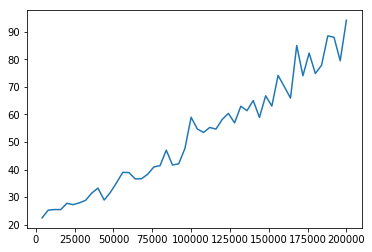

In [6]:
vpg(gym.make('CartPole-v0'), ac_kwargs=dict(hidden_sizes=[64] * 2), gamma=0.99, seed=0, steps_per_epoch=4000, epochs=50)